**Credit:** Laura Toma, March 2022.  Adapted from CS161-MIT (originally developed by Mary Wotters and modified by Nima Anari, Moses Charikar, etc)

# Divide-and-conquer example: Integer multiplication

In this notebook we implement the three algorithms  discussed in class for multiplying integers: middle-school algorithm, quadratic divide-and-conquer, and Karatsuba. 

**Goal:** Multiply two n-digit integers. 



In our implementation we'll exploit  that Python can handle arbitrarily large integers.  Try for example: 

In [1]:
2**2000


114813069527425452423283320117768198402231770208869520047764273682576626139237031385665948631650626991844596463898746277344711896086305533142593135616665318539129989145312280000688779148240044871428926990063486244781615463646388363947317026040466353970904996558162398808944629605623311649536164221970332681344168908984458505602379484807914058900934776500429002716706625830522008132236281291761267883317206598995396418127021779858404042159853183251540889433902091920554957783589672039160081957216630582755380425583726015528348786419432054508915275783882625175435528800822842770817965453762184851149029376

Python represents large integers as a list of their digits and uses a library to perform operations on them. For multiplication, it uses Karatsuba's algorithm, actually. 


**The rules:** In our implementation we are allowed to use Python's built-in multiplication to do one-digit multiplications (eg, 6 times 7), but not any other multiplication (eg, 66 times 77).  We are allowed to use Python's built-in addition (even of large numbers).

We start by writing some helper functions.

### Helper functions

In [2]:

# takes an integer x and returns a list of digits in x, most significant first
def getDigits(x): 
    return [ int(a) for a in str(x) ]

# takes a list of digits (as returned by getDigits) and returns the integer they represent
def makeInt(digits): 
    return sum( [ 10**(len(digits)-i-1)*digits[i] for i in range(len(digits))])



##let's see how this works 
a = 2315
alist = getDigits(a)
print(alist)

avalue=makeInt(alist)
print(avalue)


[2, 3, 1, 5]
2315


Create your own example here and check that it works 

### Algorithm 1:  grade-school multiplication.

This is probably (equivalent to) the algorithm you learned in middle school.

In [3]:
# @param takes as input two n-digit integers
# @return the value that represents their product
# algorithm: look at each pair of digits, and add them up with appropriate shifts.
def gradeSchoolMult( X, Y ): # X and Y are integers
    x = getDigits(X)
    y = getDigits(Y)
    #print("GradeSchoolMultiply:")
    #print("\tx=:", x)
    #print ("\ty=:", y)    
    
    #every time we multiply Y with a digit in X, we'll append the resulting integer
    #to the list sumands 
    summands = [] 
    
    for yDigit in range(len(y)):
        #initially we want the right most digit of y, moving to the left 
        currentYDigit = y[len(y) - yDigit -1]
        
        # z is the result, it will hold the digits of yDigit * X; 
        # start it out with some zeros
        z = [0 for i in range(yDigit)] 
        
        carry = 0
        for xDigit in range(len(x)):
            #initially this is right most digit of X, moving to the left 
            currentXDigit = x[len(x) - xDigit - 1]

            #multiply the current digits in X and Y 
            newProd = getDigits( currentXDigit * currentYDigit + carry )
           
            # put the new digit at the front of the result z
            z.insert( 0, newProd[-1] ) 
          
            # handle the carry 
            if len(newProd) > 1:
                carry = newProd[0]
            else:
                carry = 0
        
        # when we are done multiply Y with the currentXDigit, insert the final carry at the beginning 
        z.insert(0, carry)
        #print("yDigit=", yDigit, ": currentYDigit=", currentYDigit,  "z=", z)
        
        #claim: z represents the result of Y x currentXdigit 
        summands.append(makeInt(z))
        
    return sum(summands) # finally add them all together


Let's check that it works: 

In [4]:
## NOTE: when testing your own code, you'd want to do much more thorough tests!  

X = 1234567234934567
Y = 6543213243478758
print(gradeSchoolMult(X,Y))


8078036681588809973133584427786


Since Python can  handle large numbers, we can use it to test our result: 


In [5]:
print(X*Y)


8078036681588809973133584427786


### Algorithm 2: Naive Divide-and-conquer

This algorithm breaks one size-n multiplication into four size n/2 multiplications, and recurses.

In [6]:
# @param takes as input two n-digit integers
# @return the value that represents their product
def divideAndConquerMult( X, Y ):
    return divideAndConquerMult_helper( getDigits(X), getDigits(Y) )

def divideAndConquerMult_helper( x, y ):
    n = max( len(x), len(y) )
    # pad the shorter one with zeros until it's the same length
    while len(x) < n:
        x.insert(0,0)
    while len(y) < n:
        y.insert(0,0)
       
    #print("Naive-D&C-Multiply:")
    #print("\tx=:", x)
    #print ("\ty=:", y)    

    # this is the base case: multiplying one-digit integers
    if n == 1:
        return x[0]*y[0] 
    
    # else: 
    mid = round(n/2)
    xhigh = x[:mid] # this is [ x[0], x[1], ..., x[mid-1] ]; denoted A' in notes 
    xlow = x[mid:] # this is [ x[mid], ..., x[n-1] ]; denoted A" in notes 
    yhigh = y[:mid] #denoted B' in notes  
    ylow = y[mid:]  #denoted B" in notes 

    #compute the four products recursively 
    highhigh = divideAndConquerMult_helper( xhigh , yhigh )
    highlow = divideAndConquerMult_helper( xhigh , ylow )
    lowlow = divideAndConquerMult_helper( xlow , ylow )
    lowhigh = divideAndConquerMult_helper( xlow , yhigh )
    
    
    # xy  = highhigh*10^n + (lowhigh+highlow)*10^n/2 + lowlow
    # note: the formula above is for n=even;  
    # when n is odd, note that the length of xlow is n-mid, so we must multiply xhigh with 10^(n-mid)
    # instead of 10^n we get 10^(2*(n - mid))
    HH = getDigits(highhigh) + [ 0 for i in range(2*(n - mid))]
    MID = getDigits(lowhigh + highlow) + [0 for i in range(n-mid)]
    LL = getDigits(lowlow)
    
    result = makeInt(HH) + makeInt(MID) + makeInt(LL)
    return result

Note that the way we implemented the function above, we let Python add HH, MID and LL. 

Let's check that it works. 

In [7]:
X = 1234567435545
Y = 6543218467295867
print(divideAndConquerMult(X,Y))

8078044443380143972967392515


Python can multiply large numbers, so it should give same result: 

In [8]:
print(X*Y)

8078044443380143972967392515


### Algorithm 3:  Karatsuba multiplication

The previous algorithms ended up both using about n^2 operations.  Karatsuba multiplication is also a divide-and-conquer approach, but turns one multiplication of size n into three multiplications of size n/2.

In [9]:
# @param two n-digit integers
# @return the value that represents their product
def karatsuba( X, Y ):
    return karatsuba_helper( getDigits(X), getDigits(Y))

def karatsuba_helper( x, y ):  
    n = max( len(x), len(y) )
    # pad the shorter one with zeros until it's the same length
    while len(x) < n:
        x.insert(0,0)
    while len(y) < n:
        y.insert(0,0)
        
    # this is the base case: multiplying 1-digit integers
    if n == 1:
        return x[0]*y[0] 
    
    mid = round(n/2)
    xhigh = x[:mid] # this is [ x[0], x[1], ..., x[mid-1] ], denoted by A' in notes 
    xlow = x[mid:]  # this is [ x[mid], ..., x[n-1] ], denoted by A" in notes 
    yhigh = y[:mid] # B'
    ylow = y[mid:]  # B"
    
    # z1= A'B'
    z1 = karatsuba_helper( xhigh , yhigh )
    
    # z2= A" B"
    z2 = karatsuba_helper( xlow , ylow )
    
    # z3 = (A'+A")x (B'+B") - z1 - z2
    z3 = karatsuba_helper(getDigits( makeInt(xlow) + makeInt(xhigh) ) , 
                          getDigits( makeInt(ylow) + makeInt(yhigh) ) )
    z3 -=  z1 + z2 # this is equal to highlow + lowhigh in divideAndConquerMult1
   
   # same as before 
    HH = getDigits(z1) + [ 0 for i in range(2*(n - mid))]
    MID = getDigits(z3) + [0 for i in range(n-mid)]
    LL = getDigits(z2)
    
    result = makeInt(HH) + makeInt(MID) + makeInt(LL)
    return result

In [10]:
# make sure it works on an example:

X = 1234567
Y = 654321
print(karatsuba(X,Y))
print(X*Y)

807803114007
807803114007


# Empirical evaluation of the algorithms

Now let's see how the algorithms compare in practice!  
We'll try each algorithm a bunch of times and graph it.  


In [11]:
# set up matplotlib, for plotting stuff.
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import time
from random import choice

# multABunch: runs a multiplication function a bunch, and times how long it takes.
#
# Input: myFn: a function which takes as input two n-digit integers
#              (Notice that in python you can pass a function as input!)
#        nVals: list of n values to test at
#        note: the arguments for myFun will be generated randomly, two n-digit numbers of length n
# Output: lists nValues and tValues so that running myFn on a list of length nValues[i] 
#         took (on average over numTrials tests)  tValues[i] milliseconds.
#
# Optional arg:
#        numTrials: for each n tests, do numTrials tests and average them
def multABunch(myFn, nVals, numTrials=20):
    nValues = []
    tValues = []
    for n in nVals:
        # run myFn several times and average to get a decent idea.
        runtime = 0
        for t in range(numTrials):
            lst1 = [ choice(range(10)) for i in range(n) ] # generate a random list of length n
            lst2 = [ choice(range(10)) for i in range(n) ] # generate another random list of length n
            #convert each random list into a random large int    
            X = makeInt(lst1)
            Y = makeInt(lst2)
            start = time.time()
            myFn( X, Y )
            end = time.time()
            runtime += (end - start) * 1000 # measure in milliseconds
        runtime = runtime/numTrials
        nValues.append(n)
        tValues.append(runtime)
    return nValues, tValues



Let's test that this works. 

Running Algorithm1: 


In [13]:
# Generate the list of n values on which we'll test 
nVals = [k*50 for k in range(15)]
print(nVals)


[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]


Text(0.5, 1.0, 'Multiplying n-digit integers')

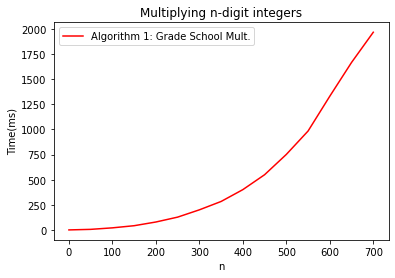

In [14]:
# run gradeSchoolMult a bunch of times 
nValsGS, tValsGS = multABunch(gradeSchoolMult, nVals, numTrials=5)

#plot the running times  
plt.plot(nValsGS, tValsGS, color="red", label="Algorithm 1: Grade School Mult.")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")


Now running the second algorithm: 

Text(0.5, 1.0, 'Multiplying n-digit integers')

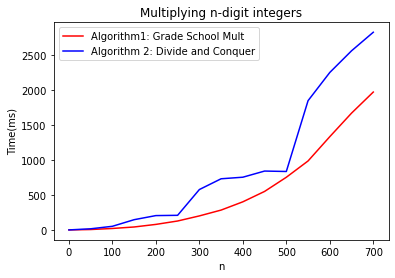

In [15]:
# run Algorithm2 a bunch of times 
nValsRec, tValsRec = multABunch(divideAndConquerMult, nVals, numTrials=5)

#plot the running times 
plt.plot(nValsGS, tValsGS, color="red", label="Algorithm1: Grade School Mult")
plt.plot(nValsRec, tValsRec, color="blue", label="Algorithm 2: Divide and Conquer")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")

As we expected, they are both quadratic.  We knew that from the theoretical analysis. 
It makes sense that the divide-and-conquer is slower because it has the overhead of recursion. 

And there's definitely something weird going on at powers of two in the divide-and-conquer implementation above.  

Now Karatsuba: 

Text(0.5, 1.0, 'Multiplying n-digit integers')

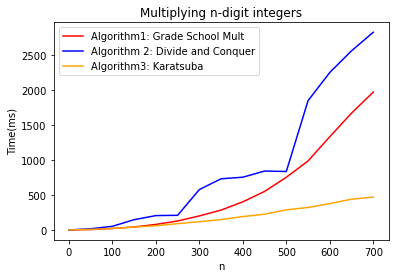

In [17]:
# run Algorithm3 a bunch of times 
nValsKarat, tValsKarat = multABunch(karatsuba, nVals, numTrials=5)

#plot the running times 
plt.plot(nValsGS, tValsGS, color="red", label="Algorithm1: Grade School Mult")
plt.plot(nValsRec, tValsRec, color="blue", label="Algorithm 2: Divide and Conquer")
plt.plot(nValsKarat, tValsKarat, color="orange", label="Algorithm3: Karatsuba")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Multiplying n-digit integers")

Clearly the winner! which we knew, based on the theoretical analysis. 

## Applications


While preparing this, I learnt about the library called "gmp" (Gnu multiple precision arithmetic library), https://gmplib.org/

The main target applications for GMP are cryptography applications and research, Internet security applications, algebra systems, computational algebra research, etc.

_GMP is carefully designed to be as fast as possible, both for small operands and for huge operands. The speed is achieved by ... using fast algorithms, with highly optimised assembly code for the most common inner loops for a lot of CPUs, and by a general emphasis on speed._

Check out the multiplication algorithms doc: 

https://gmplib.org/manual/Multiplication-Algorithms#Multiplication-Algorithms

It implements the grade-school  multiplication algorithm, Karatsuba, and five additional algorithms that are faster than Karatsuba on  large n. It chooses one of these algorithms based on the value of n: for small n it uses the quadratic, for larger n it uses Karatsuba, and for very large n it uses one of the other ones ---- it has empirically established theresholds for the value of n when switching from one algorithm to the next.  
    